In [ ]:
import os
# !pip install unrar
# !unrar x '/content/drive/MyDrive/Fatepura_satellite_dataset_800_altitude/800_dataset_with_semantic_segmentation.rar'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
plt.style.use("ggplot")
%matplotlib inline
import gc

from tqdm.notebook import trange, tqdm

from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split

import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras.layers import Conv2D, Input, MaxPooling2D, Dropout, concatenate, UpSampling2D
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from tensorflow.keras import backend as K

  
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.models import *
from tensorflow.keras.preprocessing.image import *
from tensorflow.keras.callbacks import *

import random 

## Seeding 
seed = 2019
random.seed = seed
np.random.seed = seed
tf.seed = seed

In [ ]:
w, h = 256,256
border = 5 

In [ ]:
ids = next(os.walk("/content/800_dataset_with_semantic_segmentation/train_images/"))[2] # list of names all images in the given path
print("No. of images = ", len(ids))

StopIteration: ignored

# **Data Reading and Train test split**

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
import glob
train = sorted(glob.glob("/content/drive/MyDrive/dataset4/257/images/*.png"))
train_mask = sorted(glob.glob("/content/drive/MyDrive/dataset4/257/labels/*.png"))

print(f'Total Train Images : {len(train)}\nTotal Mask Image : {len(train_mask)}')

Total Train Images : 300
Total Mask Image : 300


In [ ]:
X = np.zeros((len(train), h, w, 3), dtype=np.float32)
y = np.zeros((len(train_mask), h, w, 1), dtype=np.float32)

In [ ]:
for n, (img, mimg) in tqdm(enumerate(zip(train, train_mask))):
  # print(n, img, mimg)
  # Load images
  img = load_img(img)
  x_img = img_to_array(img)
  x_img = resize(x_img, (h, w, 3), mode = 'constant', preserve_range = True)
  # # Load masks
  mask = img_to_array(load_img(mimg, color_mode = "grayscale"))
  mask = resize(mask, (h, w, 1), mode = 'constant', preserve_range = True)
  # # Save images
  X[n] = x_img/255.0
  y[n] = mask/255.0

0it [00:00, ?it/s]

In [ ]:
print(X.shape, y.shape)

(300, 256, 256, 3) (300, 256, 256, 1)


In [ ]:
# Split train and valid
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
gc.collect()

(270, 256, 256, 3) (270, 256, 256, 1) (30, 256, 256, 3) (30, 256, 256, 1)


219

# **Visualization the image and It masks**

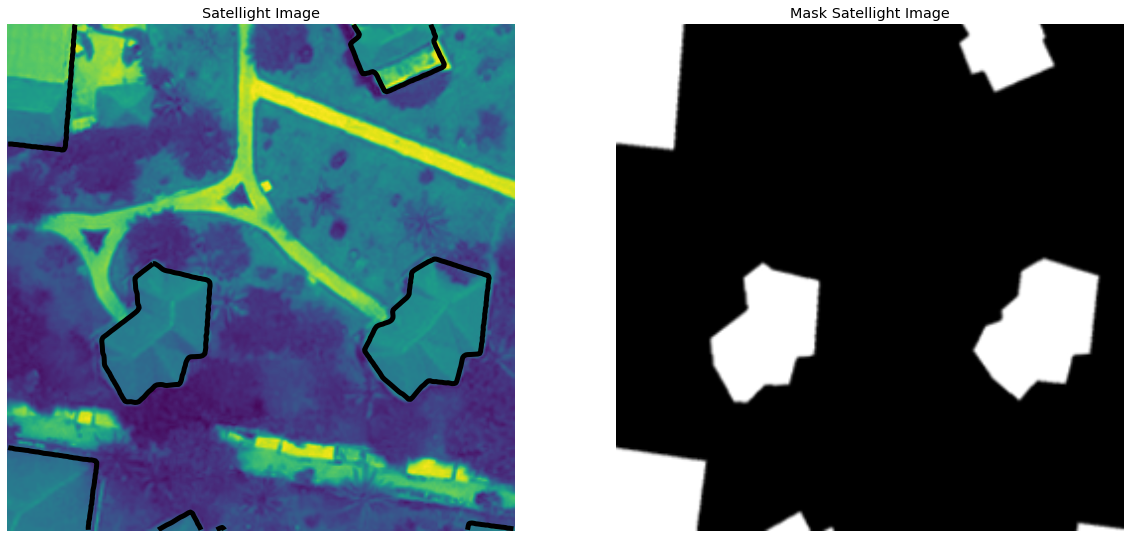

In [ ]:
# Visualize any randome image along with the mask
ix = random.randint(0, len(X_train))
has_mask = y_train[ix].max() > 0 # salt indicator

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (20, 15))

ax1.imshow(X_train[ix, ..., 0], interpolation = 'bilinear')
if has_mask: # if salt
    # draw a boundary(contour) in the original image separating salt and non-salt areas
    ax1.contour(y_train[ix].squeeze(), colors = 'k', linewidths = 5, levels = [0.5])
ax1.set_title('Satellite Image')
ax1.set_axis_off()
ax2.imshow(y_train[ix].squeeze(), cmap = 'gray', interpolation = 'bilinear')
ax2.set_title('Mask Satellite Image')
ax2.set_axis_off()

In [ ]:
def VGGUnet(image_size, vgg_weight_path='/content/drive/MyDrive/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5'):
    inputs = Input((image_size, image_size, 3))
    # Block 1
    x = Conv2D(64, (3, 3), padding='same', name='block1_conv1')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(64, (3, 3), padding='same', name='block1_conv2')(x)
    x = BatchNormalization()(x)
    block_1_out = Activation('relu')(x)

    x = MaxPooling2D()(block_1_out)

    # Block 2
    x = Conv2D(128, (3, 3), padding='same', name='block2_conv1')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(128, (3, 3), padding='same', name='block2_conv2')(x)
    x = BatchNormalization()(x)
    block_2_out = Activation('relu')(x)

    x = MaxPooling2D()(block_2_out)

    # Block 3
    x = Conv2D(256, (3, 3), padding='same', name='block3_conv1')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(256, (3, 3), padding='same', name='block3_conv2')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(256, (3, 3), padding='same', name='block3_conv3')(x)
    x = BatchNormalization()(x)
    block_3_out = Activation('relu')(x)

    x = MaxPooling2D()(block_3_out)

    # Block 4
    x = Conv2D(512, (3, 3), padding='same', name='block4_conv1')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(512, (3, 3), padding='same', name='block4_conv2')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(512, (3, 3), padding='same', name='block4_conv3')(x)
    x = BatchNormalization()(x)
    block_4_out = Activation('relu')(x)

    x = MaxPooling2D()(block_4_out)

    # Block 5
    x = Conv2D(512, (3, 3), padding='same', name='block5_conv1')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(512, (3, 3), padding='same', name='block5_conv2')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(512, (3, 3), padding='same', name='block5_conv3')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    for_pretrained_weight = MaxPooling2D()(x)

    # Load pretrained weights.
    if vgg_weight_path is not None:
      vgg16 = Model(inputs, for_pretrained_weight)
      vgg16.load_weights(vgg_weight_path, by_name=True)

    # UP 1
    x = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = concatenate([x, block_4_out])
    x = Conv2D(512, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(512, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # UP 2
    x = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = concatenate([x, block_3_out])
    x = Conv2D(256, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(256, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # UP 3
    x = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = concatenate([x, block_2_out])
    x = Conv2D(128, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(128, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # UP 4
    x = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = concatenate([x, block_1_out])
    x = Conv2D(64, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(64, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(1, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)

    outputs = Activation('sigmoid')(x)

    model = Model(inputs=inputs, outputs=outputs)
    return model

In [ ]:
from keras import backend as K
K.clear_session()

# input_img = Input((h, w, 3), name='img')
# del model
model = VGGUnet(image_size = 256)
metrics = ["accuracy", 
           tf.keras.metrics.AUC(), 
           tf.keras.metrics.SensitivityAtSpecificity(0.5), 
           tf.keras.metrics.SpecificityAtSensitivity(0.5)]
model.compile(optimizer=Adam(), loss="binary_crossentropy", metrics=metrics)
gc.collect()

297

In [ ]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 256, 256, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 256, 256, 64) 256         block1_conv1[0][0]               
__________________________________________________________________________________________________
activation (Activation)         (None, 256, 256, 64) 0           batch_normalization[0][0]        
____________________________________________________________________________________________

In [ ]:
callbacks = [
    EarlyStopping(patience=10, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.00001, verbose=1),
    ModelCheckpoint('model-VggUnet.h5', verbose=1, save_best_only=True, save_weights_only=True),
    CSVLogger("dataResUnet.csv"),
    TensorBoard(log_dir='./logs')
]

In [ ]:
results = model.fit(X_train, y_train, batch_size=6, epochs=50, callbacks=callbacks, validation_data=(X_test, y_test), use_multiprocessing=True)

Epoch 1/50
45/45 [==============================] - 94s 1s/step - loss: 0.5388 - accuracy: 0.8295 - auc: 0.8924 - sensitivity_at_specificity: 0.9287 - specificity_at_sensitivity: 0.9768 - val_loss: 4.2941 - val_accuracy: 0.2298 - val_auc: 0.7848 - val_sensitivity_at_specificity: 0.9173 - val_specificity_at_sensitivity: 0.7266

Epoch 00001: val_loss improved from inf to 4.29414, saving model to model-VggUnet.h5
Epoch 2/50
45/45 [==============================] - 49s 1s/step - loss: 0.4850 - accuracy: 0.8844 - auc: 0.9343 - sensitivity_at_specificity: 0.9521 - specificity_at_sensitivity: 0.9924 - val_loss: 10.5688 - val_accuracy: 0.2263 - val_auc: 0.6262 - val_sensitivity_at_specificity: 0.0000e+00 - val_specificity_at_sensitivity: 0.3101

Epoch 00002: val_loss did not improve from 4.29414
Epoch 3/50
45/45 [==============================] - 48s 1s/step - loss: 0.4590 - accuracy: 0.8962 - auc: 0.9433 - sensitivity_at_specificity: 0.9619 - specificity_at_sensitivity: 0.9938 - val_loss: 0.5

In [ ]:
df_result = pd.DataFrame(results.history)
df_result.sort_values('val_loss', ascending=True, inplace = True)
df_result

,loss,accuracy,auc,sensitivity_at_specificity,specificity_at_sensitivity,val_loss,val_accuracy,val_auc,val_sensitivity_at_specificity,val_specificity_at_sensitivity,lr
48,0.145944,0.962266,0.991518,0.993155,0.999963,0.164441,0.952400,0.989405,0.991196,0.999032,0.0001
49,0.142888,0.962422,0.992825,0.993717,0.999981,0.164476,0.952301,0.988735,0.990709,0.998853,0.0001
47,0.144995,0.962367,0.992364,0.992583,0.999975,0.165184,0.952127,0.989270,0.991116,0.998546,0.0001
46,0.145624,0.962262,0.992361,0.994073,0.999973,0.165546,0.952188,0.989841,0.992782,0.998602,0.0001
45,0.145977,0.962245,0.992901,0.993499,0.999969,0.166288,0.952133,0.987928,0.984795,0.998421,0.0001
44,0.147071,0.962118,0.992497,0.993270,0.999983,0.166705,0.952596,0.989407,0.988217,0.998451,0.0001
43,0.148482,0.962003,0.992423,0.993599,0.999974,0.167918,0.952073,0.989023,0.988260,0.998456,0.0001
42,0.148366,0.961941,0.993027,0.993989,0.999978,0.168107,0.952359,0.990099,0.989761,0.998390,0.0001
40,0.151530,0.961696,0.991821,0.993450,0.999968,0.168774,0.952588,0.989471,0.991443,0.998519,0.0001
41,0.147467,0.961912,0.994090,0.994619,0.999977,0.168894,0.952596,0.990172,0.991856,0.998476,0.0001


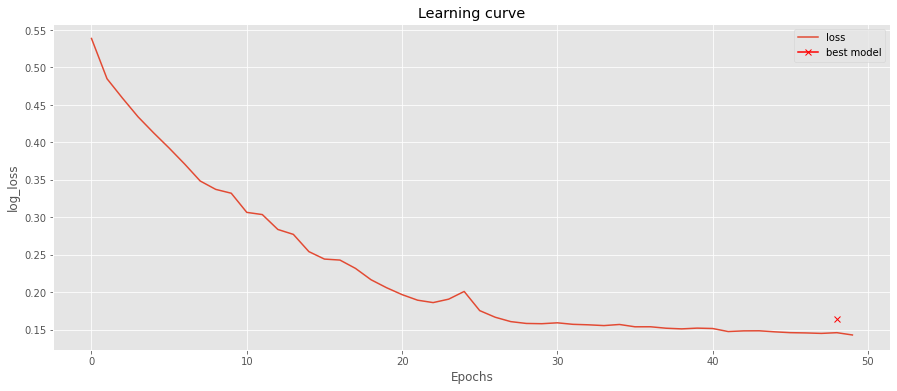

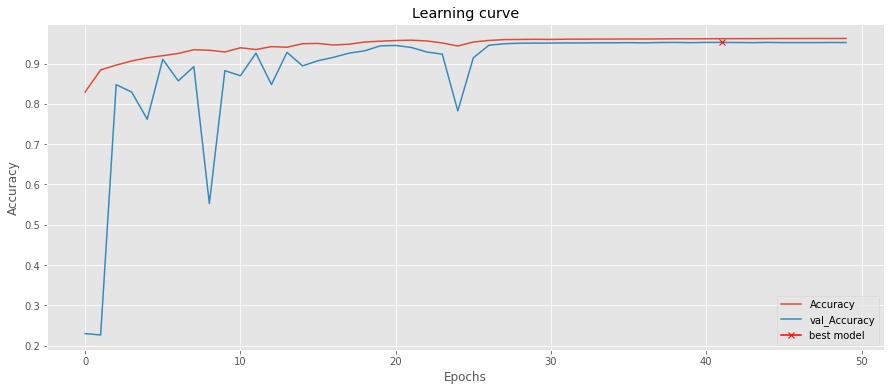

In [ ]:
plt.figure(figsize = (15,6))
plt.title("Learning curve")
plt.plot(results.history["loss"], label="loss")

plt.plot(np.argmin(results.history["val_loss"]), np.min(results.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend();

plt.figure(figsize = (15,6))
plt.title("Learning curve")
plt.plot(results.history["accuracy"], label="Accuracy")
plt.plot(results.history["val_accuracy"], label="val_Accuracy")
plt.plot(np.argmax(results.history["val_accuracy"]), np.max(results.history["val_accuracy"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend();

# **Inference**

In [ ]:
model.load_weights('/content/drive/MyDrive/model-final-final/model-VggUnet-final.h5')

In [ ]:
model.evaluate(X_test, y_test, verbose=1)

1/1 [==============================] - 15s 15s/step - loss: 0.1644 - accuracy: 0.9524 - auc: 0.9894 - sensitivity_at_specificity: 0.9912 - specificity_at_sensitivity: 0.9990


[0.16444067656993866,
 0.9524002075195312,
 0.9894052743911743,
 0.9911956191062927,
 0.9990323185920715]

In [ ]:
# Predict on train, val and test
preds_train = model.predict(X_train, verbose=1)
preds_val = model.predict(X_test, verbose=1)

1/1 [==============================] - 0s 37ms/step


In [ ]:
# Threshold predictions
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)

In [ ]:
from keras.metrics import MeanIoU
num_classes = 2
IOU_keras = MeanIoU(num_classes=num_classes)  
IOU_keras.update_state(y_train,preds_train_t)
print("Mean IoU =", IOU_keras.result().numpy())

Mean IoU = 0.92500925


In [ ]:
def plot_sample(X, y, preds, binary_preds, ix=None):
    """Function to plot the results"""
    if ix is None:
        ix = random.randint(0, len(X))

    has_mask = y[ix].max() > 0

    fig, ax = plt.subplots(1, 4, figsize=(20, 10))
    ax[0].imshow(X[ix, ..., 0], cmap='seismic')
    if has_mask:
        ax[0].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[0].set_title('Satellight Image')
    ax[0].set_axis_off()

    ax[1].imshow(y[ix].squeeze())
    ax[1].set_title('Satellight Mask Image')
    ax[1].set_axis_off()

    ax[2].imshow(preds[ix].squeeze(), vmin=0, vmax=1)
    if has_mask:
        ax[2].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[2].set_title('Satelight Image Predicted')
    ax[2].set_axis_off()
    
    ax[3].imshow(binary_preds[ix].squeeze(), vmin=0, vmax=1)
    if has_mask:
        ax[3].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[3].set_title('Satellight Mask Image Predicted binary');
    ax[3].set_axis_off()    

In [ ]:
#--------------------model2
def conv2d_block(input_tensor, n_filters, kernel_size = 3, batchnorm = True):
    """Function to add 2 convolutional layers with the parameters passed to it"""
    # first layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    # second layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    return x

def Unet(input_img, n_filters = 16, dropout = 0.1, batchnorm = True):
    """Function to define the UNET Model"""
    # Contracting Path
    c1 = conv2d_block(input_img, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    p1 = MaxPooling2D((2, 2))(c1)
    p1 = Dropout(dropout)(p1)
    
    c2 = conv2d_block(p1, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    p2 = MaxPooling2D((2, 2))(c2)
    p2 = Dropout(dropout)(p2)
    
    c3 = conv2d_block(p2, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    p3 = MaxPooling2D((2, 2))(c3)
    p3 = Dropout(dropout)(p3)
    
    c4 = conv2d_block(p3, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    p4 = MaxPooling2D((2, 2))(c4)
    p4 = Dropout(dropout)(p4)
    
    c5 = conv2d_block(p4, n_filters = n_filters * 16, kernel_size = 3, batchnorm = batchnorm)
    
    # Expansive Path
    u6 = Conv2DTranspose(n_filters * 8, (3, 3), strides = (2, 2), padding = 'same')(c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(dropout)(u6)
    c6 = conv2d_block(u6, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    
    u7 = Conv2DTranspose(n_filters * 4, (3, 3), strides = (2, 2), padding = 'same')(c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(dropout)(u7)
    c7 = conv2d_block(u7, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    
    u8 = Conv2DTranspose(n_filters * 2, (3, 3), strides = (2, 2), padding = 'same')(c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(dropout)(u8)
    c8 = conv2d_block(u8, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    
    u9 = Conv2DTranspose(n_filters * 1, (3, 3), strides = (2, 2), padding = 'same')(c8)
    u9 = concatenate([u9, c1])
    u9 = Dropout(dropout)(u9)
    c9 = conv2d_block(u9, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)
    model = Model(inputs=[input_img], outputs=[outputs])
    return model
input_img = Input((256,256, 3), name='img')
model2 = Unet(input_img, n_filters=16, dropout=0.05, batchnorm=True)   

In [ ]:
!pip install keras_unet_collection

     |████████████████████████████████| 67 kB 3.7 MB/s 


In [ ]:
from keras_unet_collection import models

In [ ]:
model3 = models.att_unet_2d((256,256, 3), filter_num=[64, 128, 256, 512, 1024], n_labels=1, 
                           stack_num_down=2, stack_num_up=2, activation='ReLU', 
                           atten_activation='ReLU', attention='add', output_activation='Sigmoid', 
                           batch_norm=True, pool=False, unpool=False, 
                           backbone='VGG16', weights='imagenet', 
                           freeze_backbone=True, freeze_batch_norm=True, 
                           name='attunet')


58900480/58889256 [==============================] - 0s 0us/step


In [ ]:
model2.load_weights('/content/drive/MyDrive/model-final-final/model-Unet-aug.h5')
model3.load_weights('/content/drive/MyDrive/model-final-final/model-ATTUnet-aug.h5')

In [ ]:
preds_train2 = model2.predict(X_train, verbose=1)
preds_val2 = model2.predict(X_test, verbose=1)
preds_train3 = model3.predict(X_train, verbose=1)
preds_val3 = model3.predict(X_test, verbose=1)

1/1 [==============================] - 50s 50s/step


# **Predictions on training set**

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
preds_train_t2 = (preds_train2 > 0.5).astype(np.uint8)
preds_val_t2 = (preds_val2 > 0.5).astype(np.uint8)
preds_train_t3 = (preds_train3 > 0.5).astype(np.uint8)
preds_val_t3 = (preds_val3 > 0.5).astype(np.uint8)

In [ ]:
def plot_sample(X, y, preds, binary_preds, ix=None):
    """Function to plot the results"""
    if ix is None:
        ix = random.randint(0, len(X))

    has_mask = y[ix].max() > 0

    fig, ax = plt.subplots(1, 4, figsize=(20, 10))
    ax[0].imshow(X[ix, ..., 0], cmap='seismic')
    if has_mask:
        ax[0].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[0].set_title('Satellight Image')
    ax[0].set_axis_off()

    ax[1].imshow(y[ix].squeeze())
    ax[1].set_title('Satellight Mask Image')
    ax[1].set_axis_off()

    ax[2].imshow(preds[ix].squeeze(), vmin=0, vmax=1)
    if has_mask:
        ax[2].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[2].set_title('Satelight Image Predicted')
    ax[2].set_axis_off()
    
    ax[3].imshow(binary_preds[ix].squeeze(), vmin=0, vmax=1)
    if has_mask:
        ax[3].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[3].set_title('Satellight Mask Image Predicted binary');
    ax[3].set_axis_off()    

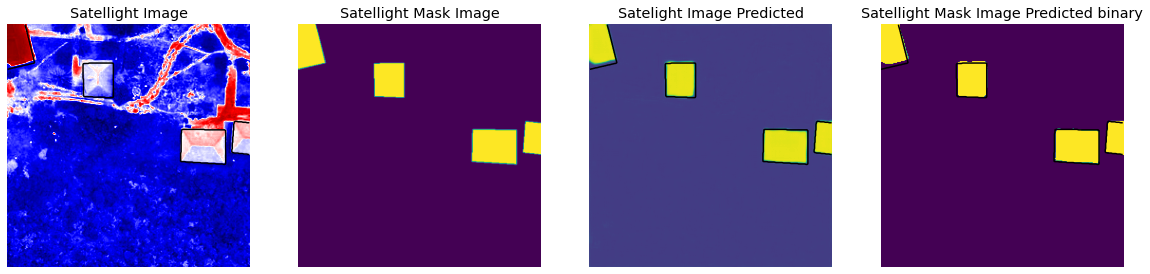

In [ ]:
# Check if training data looks all right
plot_sample(X_train, y_train, preds_train, preds_train_t, ix=2)

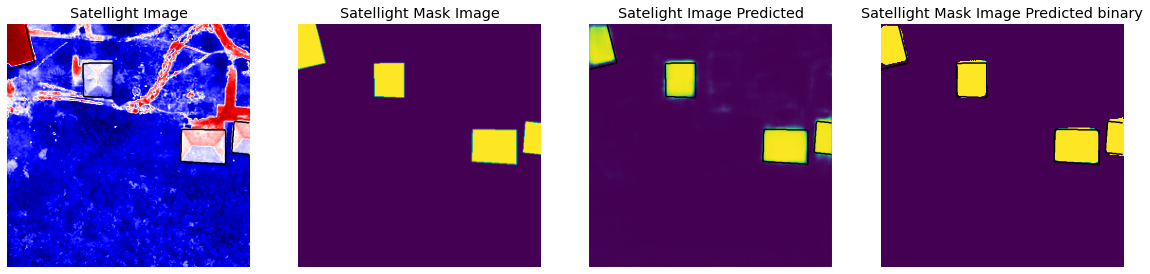

In [ ]:
plot_sample(X_train, y_train, preds_train2, preds_train_t2, ix=2)

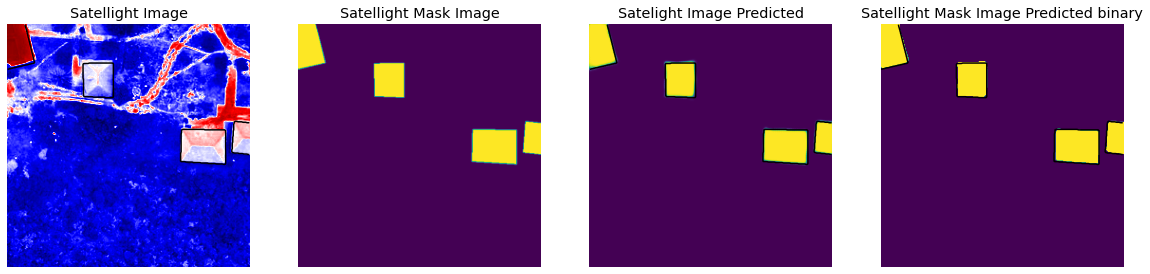

In [ ]:
plot_sample(X_train, y_train, preds_train3, preds_train_t3, ix=2)

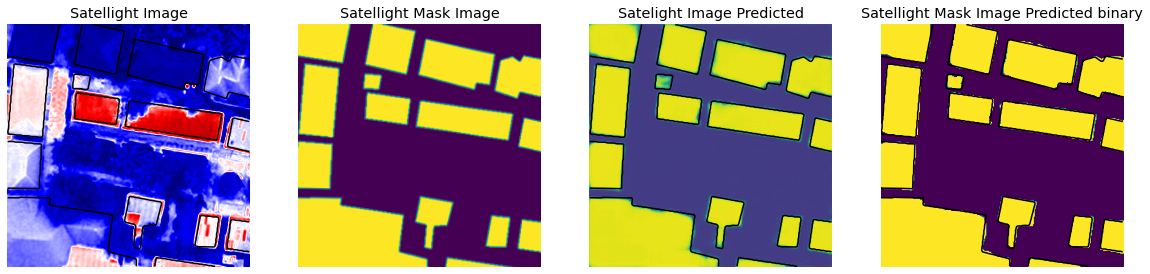

In [ ]:
plot_sample(X_train, y_train, preds_train, preds_train_t, ix=4)

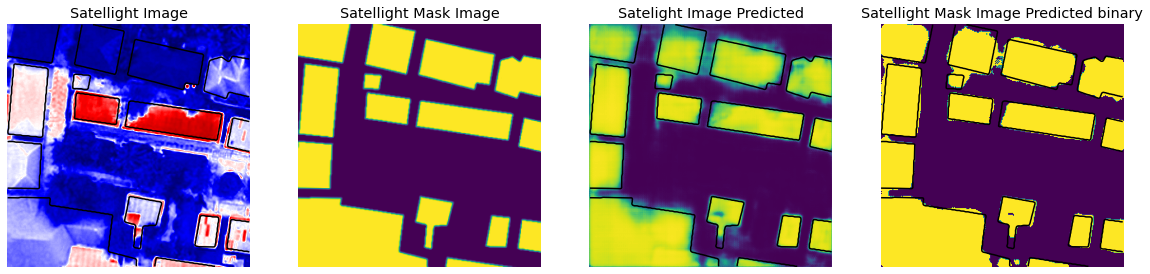

In [ ]:
plot_sample(X_train, y_train, preds_train2, preds_train_t2, ix=4)

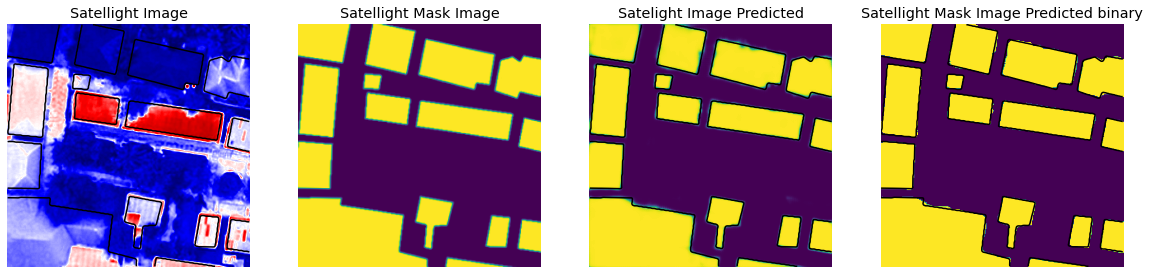

In [ ]:
plot_sample(X_train, y_train, preds_train3, preds_train_t3, ix=4)

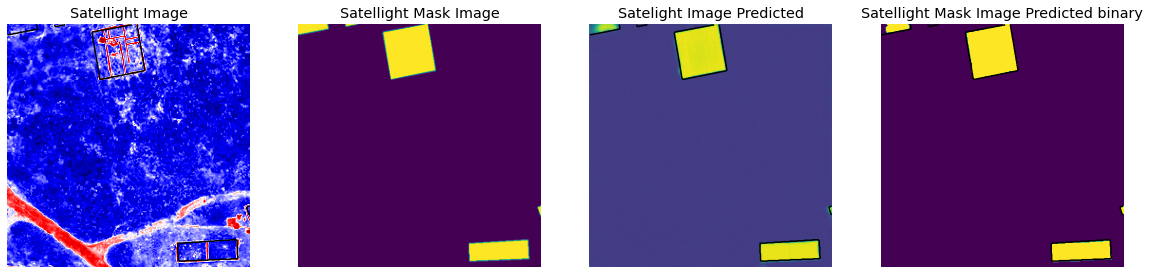

In [ ]:
plot_sample(X_train, y_train, preds_train, preds_train_t, ix=8)

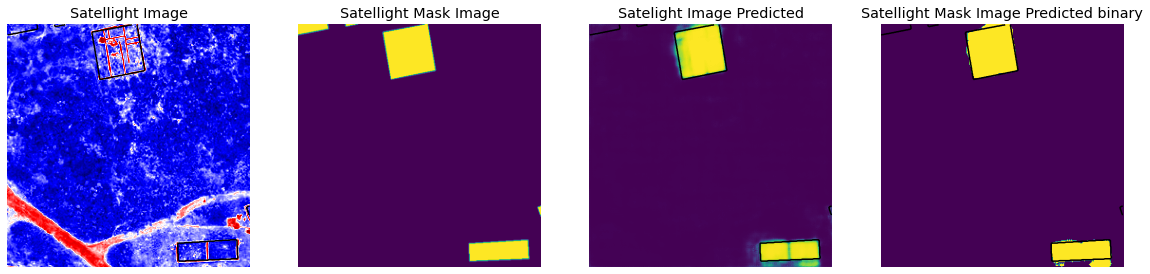

In [ ]:
plot_sample(X_train, y_train, preds_train2, preds_train_t2, ix=8)

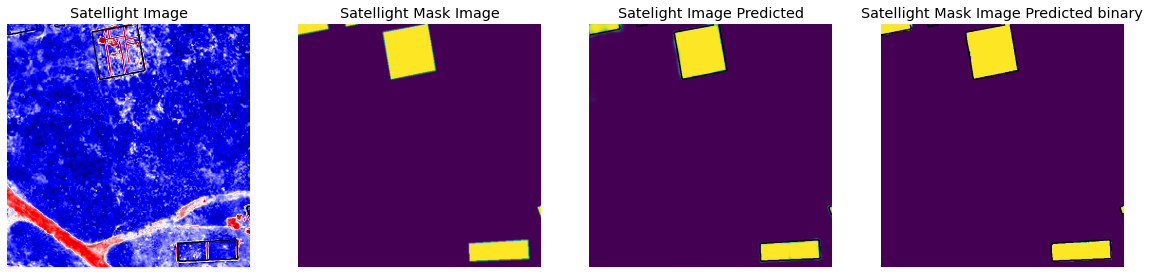

In [ ]:
plot_sample(X_train, y_train, preds_train3, preds_train_t3, ix=8)

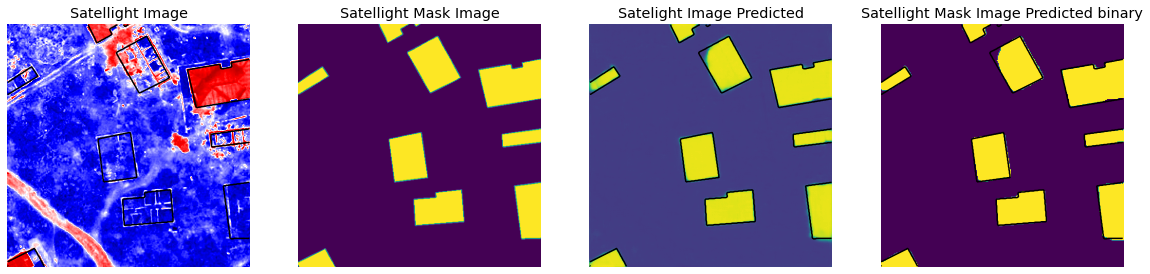

In [ ]:
plot_sample(X_train, y_train, preds_train, preds_train_t, ix=23)

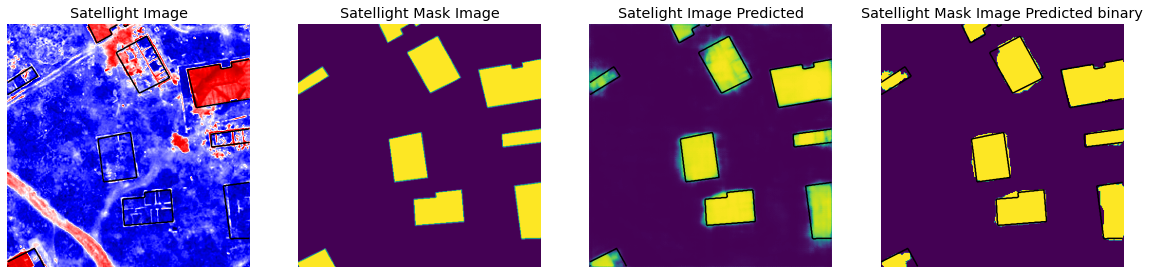

In [ ]:
plot_sample(X_train, y_train, preds_train2, preds_train_t2, ix=23)

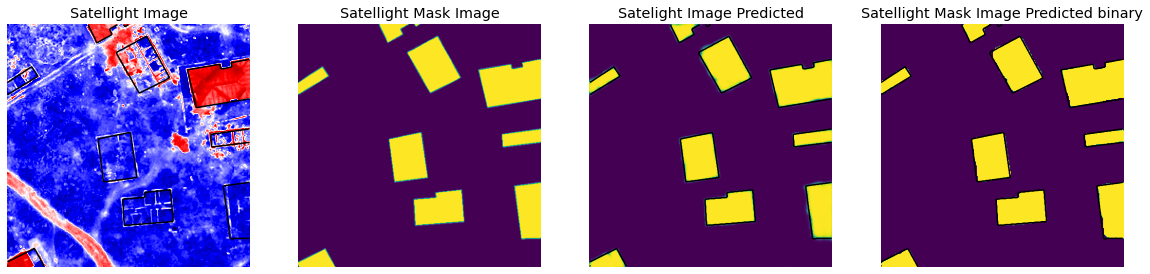

In [ ]:
plot_sample(X_train, y_train, preds_train3, preds_train_t3, ix=23)

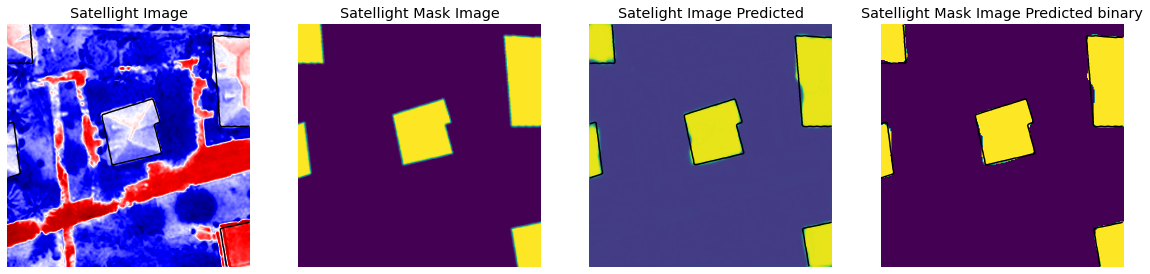

In [ ]:
plot_sample(X_train, y_train, preds_train, preds_train_t, ix=30)

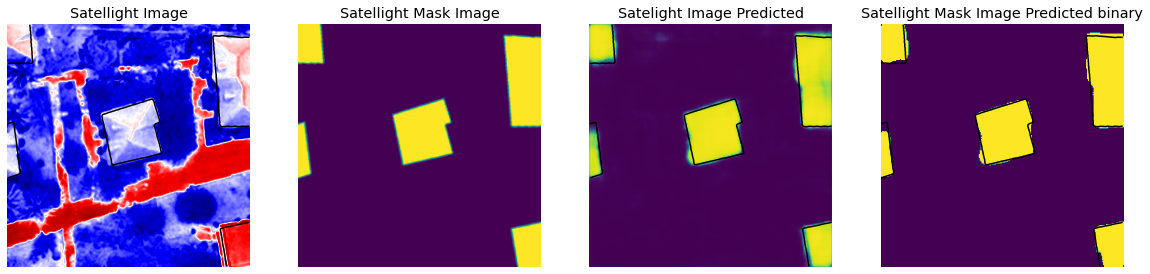

In [ ]:
plot_sample(X_train, y_train, preds_train2, preds_train_t2, ix=30)

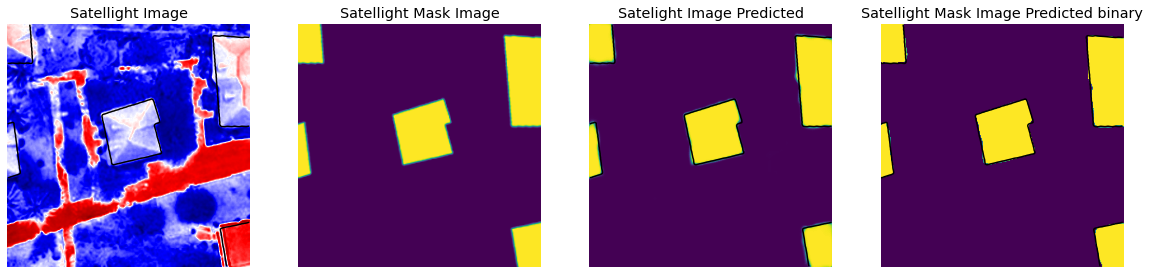

In [ ]:
plot_sample(X_train, y_train, preds_train3, preds_train_t3, ix=30)

In [ ]:
plot_sample(X_train, y_train, preds_train, preds_train_t, ix=30)

In [ ]:
model3.compile(optimizer=Adam(), loss="binary_crossentropy", metrics=metrics)
model2.compile(optimizer=Adam(), loss="binary_crossentropy", metrics=metrics)

In [ ]:
model3.evaluate(X_test, y_test, verbose=1)

1/1 [==============================] - 53s 53s/step - loss: 0.0810 - accuracy: 0.9499 - auc: 0.9857 - sensitivity_at_specificity: 0.9803 - specificity_at_sensitivity: 0.9983


[0.08104129135608673,
 0.9498672485351562,
 0.9857049584388733,
 0.9802647233009338,
 0.9983161091804504]

In [ ]:
model2.evaluate(X_test, y_test, verbose=1)

1/1 [==============================] - 5s 5s/step - loss: 0.1246 - accuracy: 0.9309 - auc: 0.9828 - sensitivity_at_specificity: 0.9882 - specificity_at_sensitivity: 0.9980


[0.12457415461540222,
 0.9308832883834839,
 0.9828007817268372,
 0.9881840944290161,
 0.9980233907699585]

In [ ]:
model.evaluate(X_test, y_test, verbose=1)

1/1 [==============================] - 50s 50s/step - loss: 0.2150 - accuracy: 0.9508 - auc: 0.9604 - sensitivity_at_specificity: 0.9405 - specificity_at_sensitivity: 0.9982


[0.21498988568782806,
 0.9508076906204224,
 0.9603805541992188,
 0.94049072265625,
 0.9981918931007385]

Mean IoU = 0.42693534
